In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from dataloaders.nascar import NascarDataLoader
from dataloaders.bouncing_data import BouncingBallDataLoader, MissingBallDataset, SquareBallDataset
from torch.utils.data import DataLoader
from models.KalmanVAE import KalmanVAE
from models.ExtendedKalmanVAE import ExtendedKalmanVAE
from models.VRNN import VRNN
from tqdm import tqdm
from utils.losses import mse_through_time


In [216]:
#dl = SquareBallDataset('/data2/users/hbz15/2_body_black_white_real_real/test_corrupt/',
#                       '/data2/users/hbz15/2_body_black_white_real_real/mask_test/')
dl = MissingBallDataset('/data2/users/hbz15/hmnist/test_missing_frame_kvae/')
train_loader = DataLoader(dl, batch_size=None, shuffle=False, num_workers=4)
im, y = next(iter(train_loader))
print(im.size())
print(y.size())

torch.Size([100, 1, 32, 32])
torch.Size([100])


In [241]:
im = torch.from_numpy(np.load('0.npz')['images'][:,np.newaxis,:,:,0])
y = torch.from_numpy(np.load('0.npz')['missing_mask'][:,0,0,0])

In [203]:
print(im.size())
print(y.size())

torch.Size([100, 1, 32, 32])
torch.Size([100])


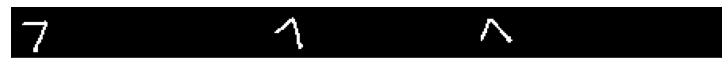

In [218]:
plt.figure(figsize=(10,10), constrained_layout=True)
plt.imshow(np.concatenate(im[:14,0].numpy(), axis=1), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
plt.savefig("fig.pdf")

In [116]:
print(y[0])

tensor(1., dtype=torch.float64)


In [2]:
from models.KalmanVAE import KalmanVAE
kvae = KalmanVAE(input_dim=1, hidden_dim=50, obs_dim=2, 
                     latent_dim=4, num_modes=3, beta=1, alpha='mlp').float().cuda()
print(kvae)
checkpoint = torch.load('/data2/users/cb221/stored_models/KVAE_mlp_10_latest.pth.tar')
kvae.load_state_dict(checkpoint['kvae'])

KalmanVAE(
  (encoder): CNNFastEncoder(
    (in_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (hidden_conv): ModuleList(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (out_mean): Linear(in_features=512, out_features=2, bias=True)
    (out_log_var): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): CNNFastDecoderKVAE(
    (in_dec): Linear(in_features=2, out_features=512, bias=True)
    (hidden_convs): ModuleList(
      (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (out_conv): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (parameter_net): MLP(
    (fc1): Linear(in_features=2, out_features=50, bias=True)
    (fc2

<All keys matched successfully>

In [205]:
x_hat, a_mu, _, losses = kvae(im.unsqueeze(0).cuda().double(), mask_visual=y.unsqueeze(0).reshape(1,100,1,1).cuda().double())
print(x_hat.size())

torch.Size([1, 100, 1, 32, 32])


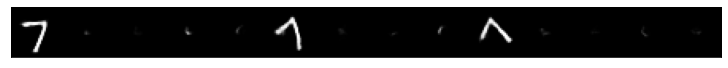

In [223]:
plt.figure(figsize=(10,10), constrained_layout=True)
plt.imshow(np.concatenate(x_hat[0,:14,0].detach().cpu().numpy(), axis=1), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
plt.savefig("kvae_missing_mnist.pdf")

In [242]:
vrnn = VRNN(1, 2, 32, 16, num_rec_layers=3, input_type='visual').float().cuda()
print(vrnn)
checkpoint = torch.load('/data2/users/cb221/stored_models/VRNN_hmnist_missing_latest.pth.tar')
vrnn.load_state_dict(checkpoint['vrnn'])

VRNN(
  (prior): MLP(
    (fc1): Linear(in_features=32, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc_final): Linear(in_features=32, out_features=32, bias=True)
  )
  (embedder_x): CNNFastEncoder(
    (in_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (hidden_conv): ModuleList(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (out_mean): Linear(in_features=2048, out_features=16, bias=True)
    (out_log_var): Linear(in_features=2048, out_features=16, bias=True)
  )
  (decoder): CNNFastDecoder(
    (in_dec): Linear(in_features=48, out_features=2048, bias=True)
    (hidden_convs): ModuleList(
      (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (out_conv): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (encoder): MLP(
   

<All keys matched successfully>

In [243]:
reconstr_seq, z_params, z_params_prior = vrnn(im.unsqueeze(0).cuda().float(), mask_frames=y.cuda().float().reshape(1,100,1,1,1))
print(reconstr_seq.size())

torch.Size([1, 100, 1, 32, 32])


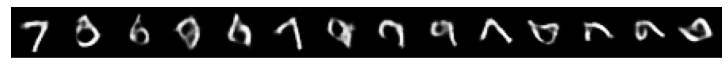

In [244]:
plt.figure(figsize=(10,10), constrained_layout=True)
plt.imshow(np.concatenate(reconstr_seq[0,:14,0].detach().cpu().numpy(), axis=1), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
plt.savefig("vrnn_missing_hmnist.pdf")

In [18]:
x_hat, a_mu, _, losses = kvae((im[:,:20] > 0.5).float().cuda())

In [30]:
kvae._kalman_posterior(a_mu, filter_only=True)[0][1][:,0]

tensor([[[ 1.9999e+01, -1.1640e-03, -9.8865e-03, -1.9081e-03],
         [-1.1640e-03,  1.9996e+01, -1.5081e-02, -2.4793e-03],
         [-9.8865e-03, -1.5081e-02,  1.9869e+01, -2.5392e-02],
         [-1.9081e-03, -2.4793e-03, -2.5392e-02,  1.9995e+01]],

        [[ 8.0183e-02,  6.5117e-05, -8.4901e-05, -6.8216e-05],
         [ 6.5117e-05,  8.0581e-02,  1.4750e-04, -1.8906e-05],
         [-8.4901e-05,  1.4750e-04,  8.0201e-02, -6.4224e-05],
         [-6.8216e-05, -1.8906e-05, -6.4224e-05,  8.0116e-02]],

        [[ 8.0001e-02,  1.7076e-07, -4.9422e-07, -3.2760e-07],
         [ 1.7076e-07,  8.0003e-02,  4.3984e-07,  9.5897e-08],
         [-4.9422e-07,  4.3984e-07,  7.9999e-02, -6.8072e-07],
         [-3.2760e-07,  9.5897e-08, -6.8072e-07,  8.0000e-02]],

        [[ 8.0001e-02,  1.6729e-07, -4.9513e-07, -3.2565e-07],
         [ 1.6729e-07,  8.0003e-02,  4.3426e-07,  9.8900e-08],
         [-4.9513e-07,  4.3426e-07,  7.9999e-02, -6.7968e-07],
         [-3.2565e-07,  9.8900e-08, -6.7968e-07, 

In [15]:
for i in range(4):
    plt.scatter(a_mu[i,:,0],a_mu[i,:,1], s=10)

NameError: name 'a_mu' is not defined

(100, 100)
torch.Size([100, 100, 2])


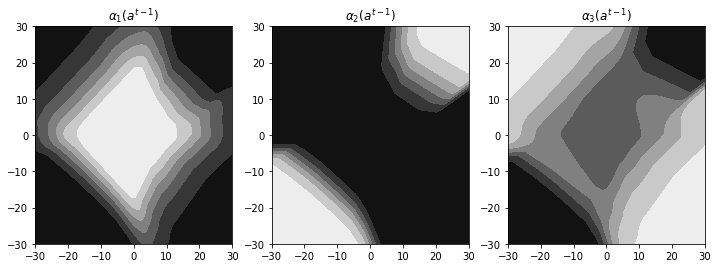

In [6]:
import matplotlib
N = 100
xlist = np.linspace(-30, 30, N)
ylist = np.linspace(-30, 30, N)
X, Y = np.meshgrid(xlist, ylist)
print(X.shape)
X_t = torch.from_numpy(X).unsqueeze(-1)
Y_t = torch.from_numpy(Y).unsqueeze(-1)
dom = torch.cat([X_t,Y_t], dim=-1).float()
print(dom.size())
#out, (h, c) = kvae.cpu().parameter_net(dom.reshape(-1, 2))
#Z = kvae.cpu().alpha_out(out)
Z = kvae.cpu().parameter_net(dom.reshape(-1,2))
Z = (Z).softmax(-1).reshape(N,N,-1).detach().numpy()

fig = plt.figure(figsize=(12,4))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    plt.title(r'$\alpha_{}$'.format(i+1) + r'$(a^{t-1})$')
    cp = ax.contourf(X, Y, Z[:,:,i], cmap='gray')

plt.savefig('kvae_wall_alpha.pdf')
plt.show()

In [3]:
smoothed_cov = torch.from_numpy(np.load('smoothed_cov.npy'))
obs = torch.from_numpy(np.load('error_obs.npy'))
A_t = torch.from_numpy(np.load('error_A.npy'))
C_t = torch.from_numpy(np.load('error_C.npy'))

print(smoothed_cov.size())
print(obs.size())
print(A_t.size())
print(C_t.size())

torch.Size([100, 32, 16, 16])
torch.Size([20, 32, 2])
torch.Size([32, 20, 4, 4])
torch.Size([32, 20, 2, 4])


In [219]:
filt, pred = kvae._filter_posterior(obs.cuda(),A_t.cuda(),C_t.cuda())
smoooth = kvae._smooth_posterior(A_t.cuda(), filt, pred)

In [140]:
J_1 = torch.matmul(filt[1][0], torch.matmul(torch.transpose(A_t.cuda()[:,1,:,:], 1,2), torch.inverse(pred[1][1])))
cov_diff = smoooth[1][1] - pred[1][1]
Sigma_z_smooth = filt[1][0] + torch.matmul(torch.matmul(J_1, cov_diff), torch.transpose(J_1, 1, 2))

In [4]:
torch.linalg.det(torch.matmul(torch.matmul(J_1, cov_diff), torch.transpose(J_1, 1, 2)))

NameError: name 'J_1' is not defined

In [58]:
print(smoothed_cov.size())

torch.Size([100, 32, 16, 16])


In [59]:
(torch.linalg.det(smoothed_cov[:,:] +0.01*torch.eye(16).reshape(1,1,16,16)) < 0).any()

tensor(True)

In [90]:
torch.linalg.det(smoothed_cov[0,27] + torch.eye(4)*1e-3)

tensor(-0.0077)

In [128]:
smoothed_cov1 = torch.from_numpy(np.load('error_cov.npy'))
smoothed_z = torch.distributions.MultivariateNormal(torch.zeros(20,32,10,1)[1:].squeeze(-1), 
                        scale_tril=torch.linalg.cholesky((smoothed_cov1)[1:]))

RuntimeError: torch.linalg.cholesky: For batch 11: U(2,2) is zero, singular U.

torch.Size([20, 32, 4, 4])


In [129]:
for i in range(20):
    if i!=0:
        for j in range(32):
            print(i,j)
            torch.linalg.cholesky(smoothed_cov1[i,j])

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11


RuntimeError: torch.linalg.cholesky: U(2,2) is zero, singular U.

In [123]:
torch.linalg.det(smoothed_cov1)

tensor([[ 5.0867e-01,  5.1886e-01,  2.3283e-01,  5.2988e-01,  5.2998e-01,
          4.8118e-01,  5.3023e-01,  5.2261e-01,  5.3443e-01,  5.0997e-01,
          3.0213e-01,  5.3414e-01,  3.1354e-01,  2.5297e-01,  3.0302e-01,
          2.4683e-01,  2.8035e-01,  3.7066e-02,  5.3540e-01,  4.1462e-01,
         -5.9253e-02,  5.2757e-01,  2.1511e-01,  5.2375e-01,  5.3541e-01,
          5.1303e-01,  1.2758e-01,  3.2135e-01,  5.2464e-01,  4.9956e-01,
          3.7841e-01,  4.6144e-01],
        [ 9.9691e-05,  1.0201e-04,  8.2093e-05,  1.0577e-04,  1.0732e-04,
          9.7354e-05,  1.0752e-04,  1.0351e-04,  1.0494e-04,  9.8539e-05,
          8.7823e-05,  1.0458e-04,  8.7599e-05,  8.2439e-05,  8.7634e-05,
          8.4933e-05,  8.3141e-05,  7.8848e-05,  1.0786e-04,  8.9438e-05,
          7.6807e-05,  1.0292e-04,  8.1322e-05,  1.0248e-04,  1.0630e-04,
          1.0029e-04,  7.9255e-05,  8.4756e-05,  1.0397e-04,  9.7517e-05,
          8.8291e-05,  9.6308e-05],
        [ 2.8739e-05,  2.9975e-05,  2.06

In [213]:
from pykalman import KalmanFilter
import numpy as np
A = np.array([
    [1, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
Q = 0.08*np.eye(4)
R = 0.03*np.eye(2)
C = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])
kf = KalmanFilter(transition_matrices=A_t[5,1:].numpy(), observation_matrices=C_t[5].numpy(), transition_covariance=Q, 
                  observation_covariance=R, initial_state_mean=np.zeros(4),
                  initial_state_covariance=20*np.eye(4))
points = np.load('datasets/trimmed_datapoints.npy')[0][:10]

In [161]:
print(obs.size())

torch.Size([15, 32, 2])


In [214]:
(filtered_state_means, filtered_state_covariances) = kf.filter(obs[:,5].numpy())
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(obs[:,5].numpy())

In [195]:
kf._sm

AttributeError: 'KalmanFilter' object has no attribute '_smooth'

In [220]:
torch.linalg.det(torch.from_numpy(smoothed_state_covariances))

tensor([4.6854e-02, 1.1070e-06, 1.0927e-06, 1.1270e-06, 1.0096e-06, 1.0866e-06,
        1.0931e-06, 1.3040e-06, 1.3809e-06, 1.4235e-06, 1.6187e-06, 1.8287e-06,
        2.1697e-06, 2.3959e-06, 3.6076e-06], dtype=torch.float64)

In [221]:
torch.linalg.det(smoooth[1][:,5,:,:])

tensor([4.6856e-02, 1.1070e-06, 1.0927e-06, 1.1270e-06, 1.0096e-06, 1.0866e-06,
        1.0931e-06, 1.3040e-06, 1.3809e-06, 1.4235e-06, 1.6187e-06, 1.8287e-06,
        2.1697e-06, 2.3959e-06, 3.6076e-06], device='cuda:0')

In [222]:
smoothed_state_means

array([[ 9.56760022e+00,  2.11193822e+00,  6.18172624e+00,
         1.10753267e+00],
       [ 2.40075214e+00,  7.48972007e-01, -1.58744427e+00,
        -1.84152784e+00],
       [ 2.32200393e+00,  7.68538984e-01, -1.52551971e+00,
        -1.86565373e+00],
       [ 1.34243462e+00,  1.27861197e+00, -6.64422061e-01,
        -1.83874470e+00],
       [ 1.07220678e+00,  1.17369377e+00, -4.89412118e-01,
        -1.61736547e+00],
       [ 9.93393832e-01,  1.21357787e+00, -3.53964867e-01,
        -1.57082712e+00],
       [ 7.90703861e-01,  1.10228870e+00, -2.94490711e-01,
        -1.40049557e+00],
       [ 7.58225910e-01,  1.15740149e+00, -2.18504607e-01,
        -1.40314340e+00],
       [ 6.69454422e-01,  1.21093709e+00, -1.23960944e-01,
        -1.39578837e+00],
       [ 5.82232747e-01,  1.13922326e+00, -9.88303150e-02,
        -1.29670033e+00],
       [ 4.69581731e-01,  1.15078495e+00, -6.68132233e-03,
        -1.24282408e+00],
       [ 3.40311454e-01,  1.14942206e+00,  7.43416512e-02,
      

In [223]:
smoooth[0][:,5,:,0]

tensor([[ 9.5676e+00,  2.1119e+00,  6.1817e+00,  1.1075e+00],
        [ 2.4008e+00,  7.4897e-01, -1.5874e+00, -1.8415e+00],
        [ 2.3220e+00,  7.6854e-01, -1.5255e+00, -1.8657e+00],
        [ 1.3424e+00,  1.2786e+00, -6.6442e-01, -1.8387e+00],
        [ 1.0722e+00,  1.1737e+00, -4.8941e-01, -1.6174e+00],
        [ 9.9339e-01,  1.2136e+00, -3.5396e-01, -1.5708e+00],
        [ 7.9070e-01,  1.1023e+00, -2.9449e-01, -1.4005e+00],
        [ 7.5823e-01,  1.1574e+00, -2.1850e-01, -1.4031e+00],
        [ 6.6945e-01,  1.2109e+00, -1.2396e-01, -1.3958e+00],
        [ 5.8223e-01,  1.1392e+00, -9.8830e-02, -1.2967e+00],
        [ 4.6958e-01,  1.1508e+00, -6.6813e-03, -1.2428e+00],
        [ 3.4031e-01,  1.1494e+00,  7.4342e-02, -1.1815e+00],
        [ 3.1812e-01,  1.1880e+00,  1.2612e-01, -1.1879e+00],
        [ 2.8204e-01,  1.2231e+00,  1.7204e-01, -1.1950e+00],
        [ 2.0597e-01,  1.2200e+00,  2.0688e-01, -1.1657e+00]], device='cuda:0')

In [189]:
torch.linalg.det(smoooth[1][:,5])

tensor([-5.1020e-02,  1.0816e-06,  1.0922e-06,  1.1271e-06,  1.0095e-06,
         1.0866e-06,  1.0930e-06,  1.3038e-06,  1.3808e-06,  1.4231e-06,
         1.6180e-06,  1.8276e-06,  2.1683e-06,  2.3954e-06,  3.6073e-06],
       device='cuda:0')

In [156]:
kvae = KalmanVAE(1,128,2,4,1,1, 'rnn').float()

TypeError: super(type, obj): obj must be an instance or subtype of type

In [54]:
A_t = torch.from_numpy(A).unsqueeze(0).unsqueeze(0).repeat(1,10,1,1).cuda().float()
C_t = torch.from_numpy(C).unsqueeze(0).unsqueeze(0).repeat(1,10,1,1).cuda().float()
(m, cov), (p_m, p_c) = kvae._filter_posterior(torch.from_numpy(points).unsqueeze(0).transpose(0,1).cuda().float(), A_t, C_t)

In [58]:
smooth_m, smooth_c = kvae._smooth_posterior(A_t, (m,cov), (p_m, p_c))

In [66]:
smooth_c[:,0,:,:]

tensor([[[ 2.7046e-02,  0.0000e+00, -1.5178e-02,  0.0000e+00],
         [ 0.0000e+00,  2.3219e-02,  0.0000e+00,  0.0000e+00],
         [-1.5178e-02,  0.0000e+00,  6.1729e-02,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.0000e+01]],

        [[ 2.1304e-02,  0.0000e+00, -4.6693e-03,  0.0000e+00],
         [ 0.0000e+00,  1.9189e-02,  0.0000e+00,  0.0000e+00],
         [-4.6693e-03,  0.0000e+00,  4.2795e-02,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.0080e+01]],

        [[ 2.1291e-02,  0.0000e+00, -4.8781e-03,  0.0000e+00],
         [ 0.0000e+00,  1.8985e-02,  0.0000e+00,  0.0000e+00],
         [-4.8781e-03,  0.0000e+00,  3.9851e-02,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.0160e+01]],

        [[ 2.1198e-02,  0.0000e+00, -5.0563e-03,  0.0000e+00],
         [ 0.0000e+00,  1.8974e-02,  0.0000e+00,  0.0000e+00],
         [-5.0563e-03,  0.0000e+00,  3.9508e-02,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, 

In [63]:
smoothed_state_covariances

array([[[ 2.70463096e-02, -7.88541706e-19, -1.51781291e-02,
          0.00000000e+00],
        [-7.88541706e-19,  2.32185668e-02,  3.99801577e-18,
          0.00000000e+00],
        [-1.51781291e-02,  3.99801577e-18,  6.19689213e-02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          2.00000000e+01]],

       [[ 2.13042813e-02, -2.01768556e-20, -4.66926562e-03,
          0.00000000e+00],
        [-2.01768556e-20,  1.91888473e-02,  1.21241105e-19,
          0.00000000e+00],
        [-4.66926562e-03,  1.21241105e-19,  4.27947974e-02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          2.00800000e+01]],

       [[ 2.12905423e-02, -5.35899874e-20, -4.87813399e-03,
          0.00000000e+00],
        [-5.35899874e-20,  1.89845739e-02,  1.29279254e-18,
          0.00000000e+00],
        [-4.87813399e-03,  1.29279254e-18,  3.98512509e-02,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+

100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


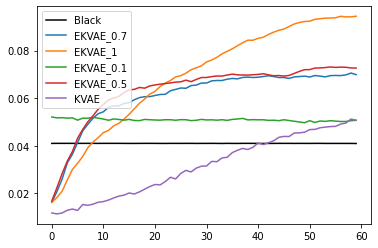

In [21]:
with torch.no_grad():
    dl = BouncingBallDataLoader('/data2/users/cb221/2_body_black_white/test', False)
    train_loader = torch.utils.data.DataLoader(dl, batch_size=128, shuffle=True)
    im = next(iter(train_loader))
    models = [
        '0.7',
        '1',
        '0.1',
        '0.5',
    ]
    fig = plt.figure()
    T=60
    target_ = im[:,30:30+T].float().cuda()
    mse_t_t = mse_through_time(torch.zeros_like(target_), target_).cpu().detach().numpy()
    plt.plot(range(T),mse_t_t, label='Black',c='k')
    for i in tqdm(range(len(models))):
        kvae = ExtendedKalmanVAE(input_dim=1, hidden_dim=32, obs_dim=4, 
                                latent_dim=6, beta=1).float().cuda() 
        checkpoint = torch.load('/data2/users/cb221/stored_models/EKVAE_beta_'+ models[i] +'_latest.pth.tar')
        kvae.load_state_dict(checkpoint['kvae'])
        T=60
        pred_, _, _ = kvae.predict_sequence(im[:,:30].float().cuda(),seq_len=T)
        
        pred_mse = F.mse_loss(pred_, target_)
        mse_t_t = mse_through_time(pred_, target_).cpu().detach().numpy()
        plt.plot(range(T),mse_t_t, label='EKVAE_' + models[i])

    kvae = KalmanVAE(input_dim=1, hidden_dim=32, obs_dim=4, 
                    latent_dim=6, num_modes=10, beta=1, 
                    alpha='rnn').float().cuda()
    checkpoint = torch.load('/data2/users/cb221/stored_models/KVAE_2_body_latest.pth.tar')
    kvae.load_state_dict(checkpoint['kvae'])
    T=60
    pred_, _, _ = kvae.predict_sequence(im[:,:30].float().cuda(),seq_len=T)
    target_ = im[:,30:30+T].float().to(pred_.device)
    pred_mse = F.mse_loss(pred_, target_)
    mse_t_t = mse_through_time(pred_, target_).cpu().detach().numpy()
    plt.plot(range(T),mse_t_t, label='KVAE')
plt.legend()
plt.show()